In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import io
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
  
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

from typing import List
from masks import ring_mask, box_mask, dot_mask
from load_compression_models import (
    my_bmshj2018_factorized, 
    my_bmshj2018_factorized_relu,
    my_bmshj2018_hyperprior,
    my_cheng2020_anchor,
    my_cheng2020_attn,
    my_mbt2018,
    my_mbt2018_mean
)
from compressai.losses import RateDistortionLoss

### Load the Compression Networks

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'

In [3]:
models = {
    'my_bmshj2018_factorized_relu': my_bmshj2018_factorized_relu(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_factorized'     : my_bmshj2018_factorized(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_hyperprior'     : my_bmshj2018_hyperprior(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_anchor'         : my_cheng2020_anchor(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_attn'           : my_cheng2020_attn(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018'                  : my_mbt2018(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018_mean'             : my_mbt2018_mean(quality=2, pretrained=True).to(torch.float32).train().to(device)
}
net = models['my_bmshj2018_factorized']
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Load the Dataset

In [4]:
# Define the transformations
img_WH = 256
transform = transforms.Compose([
    transforms.Resize((img_WH, img_WH)),
    transforms.ToTensor(),
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Files already downloaded and verified


### Run Attack

In [5]:
class StatsMeter:
    # Utility function to track statistics of a variable
    # over time
    def __init__(self) -> None:
        self.data = []
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0
        self.min = float('inf')

    def update(self, val : float, n : int = 1) -> None:
        self.count += n
        self.data.append(val)
        self.sum = sum(self.data)
        self.avg = self.sum / len(self.data)
        self.max = max(self.data)
        self.min = min(self.data)

In [6]:
x = dataset[0][0].unsqueeze(0).to(device)

num_sources = 4
x_hat = [] #dataset[1][0].unsqueeze(0).to(device)
for i, (images, label) in enumerate(dataloader):
    # num sources must be less than batch size
    x_hat = images[:num_sources].to(device)
    break

x_src = x_hat.clone()
x_hat.requires_grad = True

In [7]:
class CustomLRScheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: torch.Tensor, 
                 update_every: int = 1000, 
                 update_factor: int = 10, 
                 last_epoch: int = -1):
        self.update_every = update_every
        self.update_factor = update_factor
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        # Change the learning rate every 'reduce_every' epochs
        if (self.last_epoch + 1) % self.update_every == 0:
            return [group['lr'] / 1000 for group in self.optimizer.param_groups]
        else:
            return [group['lr'] for group in self.optimizer.param_groups]

In [8]:
def loss_fn(src: torch.Tensor, target: torch.Tensor, iter: int, num_steps: int) -> torch.Tensor:
    mse = F.mse_loss(src, target) 
    cos_sim = F.cosine_similarity(src.view(1, -1), target.view(num_sources, -1), dim=1).mean()
    inf_norm = torch.dist(src, target, p=float('inf'))
    if iter < num_steps // 2:
        loss = mse + ((1 - cos_sim) / 2)
    else:
        loss = inf_norm
    return loss

In [9]:
def pgd(
        src_img: torch.Tensor, 
        target_img: torch.Tensor, 
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        scheduler: torch.optim.lr_scheduler._LRScheduler, 
        num_steps: int, 
        mask: torch.Tensor = None
    ) -> List:
    # Move images to the same device as the model
    src_img = src_img.to(device)
    target_img = target_img.to(device)
    mask = mask.to(device)
    # Get the embedding of the source image and make a copy of the target
    src_emb = model.forward(src_img)['y_hat']

    # Track the best performance
    best_img = None
    loss_tracker = StatsMeter()

    pbar = tqdm(range(num_steps))
    for iter in pbar:  
        out = model.forward(target_img)
        target_emb = out['y_hat']
        loss = loss_fn(src_emb, target_emb, iter, num_steps)
        pbar.set_description(f"[Running attack]: Loss {loss.item()}")

        optimizer.zero_grad()
        target_img.grad,  = torch.autograd.grad(loss, [target_img])
        # loss.backward(retain_graph=True)
        if mask is not None:
            target_img.grad *= mask
        optimizer.step()
        scheduler.step()
        loss_tracker.update(loss.item())

        # Save the image that achieved the best performance
        if loss.item() == loss_tracker.min:
            best_img = target_img

    return best_img, loss_tracker

In [10]:
# Set hyperparams for mask generation and PGD itself
num_steps = 10000
mask_type = 'dot'
if mask_type == 'box':
    lr = 3e-3
    mask = box_mask()
elif mask_type == 'ring':
    lr = 3e-3
    num_rings = 50
    ring_width = 1
    ring_separation = 5
    mask = ring_mask(x_hat, num_rings=num_rings, ring_width=ring_width, ring_separation=ring_separation)
elif mask_type == 'dot':
    lr = 5e-2
    vertical_skip = 2
    horizontal_skip = 3
    mask = dot_mask(x_hat, vertical_skip=vertical_skip, horizontal_skip=horizontal_skip)

# Run the attack and produce an adversarial image y_hat
optimizer = torch.optim.Adam([x_hat], lr=lr)
scheduler = CustomLRScheduler(optimizer, update_every=num_steps // 2, update_factor=.15)
x_adv, loss_tracker = pgd(x, x_hat, model=net, optimizer=optimizer, scheduler=scheduler, num_steps=num_steps, mask=mask)
# Pass the adv image through the compression network and see the result
output = net.forward(x_adv)['x_hat']

[Running attack]: Loss 0.021270286291837692: 100%|██████████| 10000/10000 [01:44<00:00, 95.62it/s] 


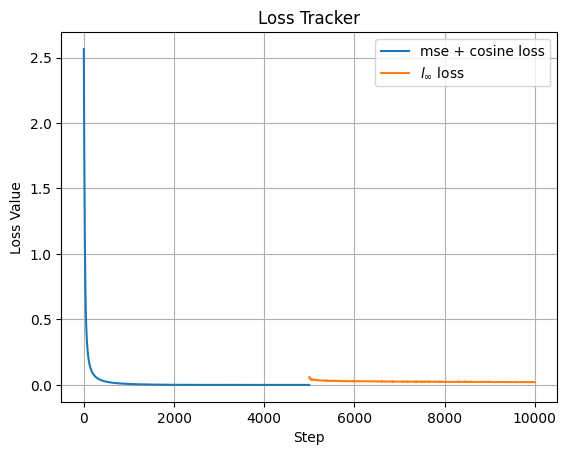

In [11]:
# Show how the loss changed during optimization
plt.plot(torch.linspace(0, num_steps//2, num_steps//2), loss_tracker.data[:num_steps//2], label='mse + cosine loss')
plt.plot(torch.linspace(num_steps//2, num_steps, num_steps//2), loss_tracker.data[num_steps//2:], label = '$l_{\infty}$ loss')
plt.xlabel('Step')
plt.ylabel('Loss Value')
plt.title('Loss Tracker')
plt.legend()
plt.grid()
plt.show()

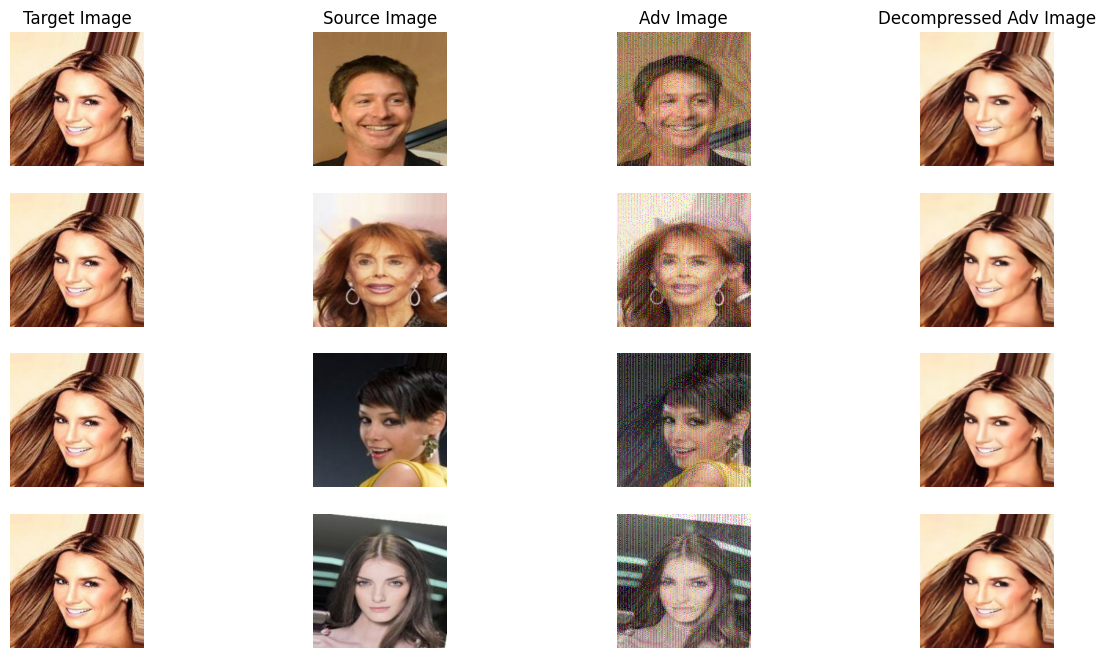

In [12]:
# Create a figure to hold the subplots
fig, axs = plt.subplots(num_sources, 4, figsize=(15, 8))  # num_sources rows, 4 columns
labels = ['Target Image', 'Source Image', 'Adv Image', 'Decompressed Adv Image']

for idx in range(num_sources):
    images = [x, x_src[idx], x_adv[idx], output[idx]]
    
    # Iterate over the images and axes to plot each image
    for img_idx, ax in enumerate(axs[idx] if num_sources > 1 else axs):  # Use idx for outer loop, img_idx for inner
        img = images[img_idx].clip(0, 1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Change the shape to [H, W, C]
        ax.imshow(img)
        if idx == 0:
            ax.set_title(labels[img_idx])
        ax.axis('off')  # Hide axis

plt.show()

### Performance Metrics

Similarity between the adversarial output of the network and the target image

In [13]:
def calculate_psnr(img1, img2, max_val=1.0):
    # img1 and img2 should be of shape (batch_size, channels, height, width) and normalized to [0, 1] range
    mse = F.mse_loss(img1, img2)
    psnr = 10 * torch.log10(max_val / torch.sqrt(mse))
    return psnr

In [14]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(num_sources):
    normalized_l2_dist.append(torch.norm(x - output[i]) / (3 * img_WH * img_WH))
    struct_sim.append(ssim(x, output[i].unsqueeze(0)))
    psnr.append(calculate_psnr(x, output[i]))

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 9.566426160745323e-05
SSIM: 0.9999363422393799
PSNR: 13.72451400756836


Similarity between the source image and the adversarial image

In [15]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(num_sources):
    normalized_l2_dist = torch.norm(x_src[i] - x_adv[i]) / (3 * img_WH * img_WH)
    struct_sim = ssim(x_src[i].unsqueeze(0), x_adv[i].unsqueeze(0))
    psnr = calculate_psnr(x_src[i], x_adv[i])

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 0.004809715785086155
SSIM: 0.9061776995658875
PSNR: -3.2892000675201416


### Interpolate between Source and Adv Images

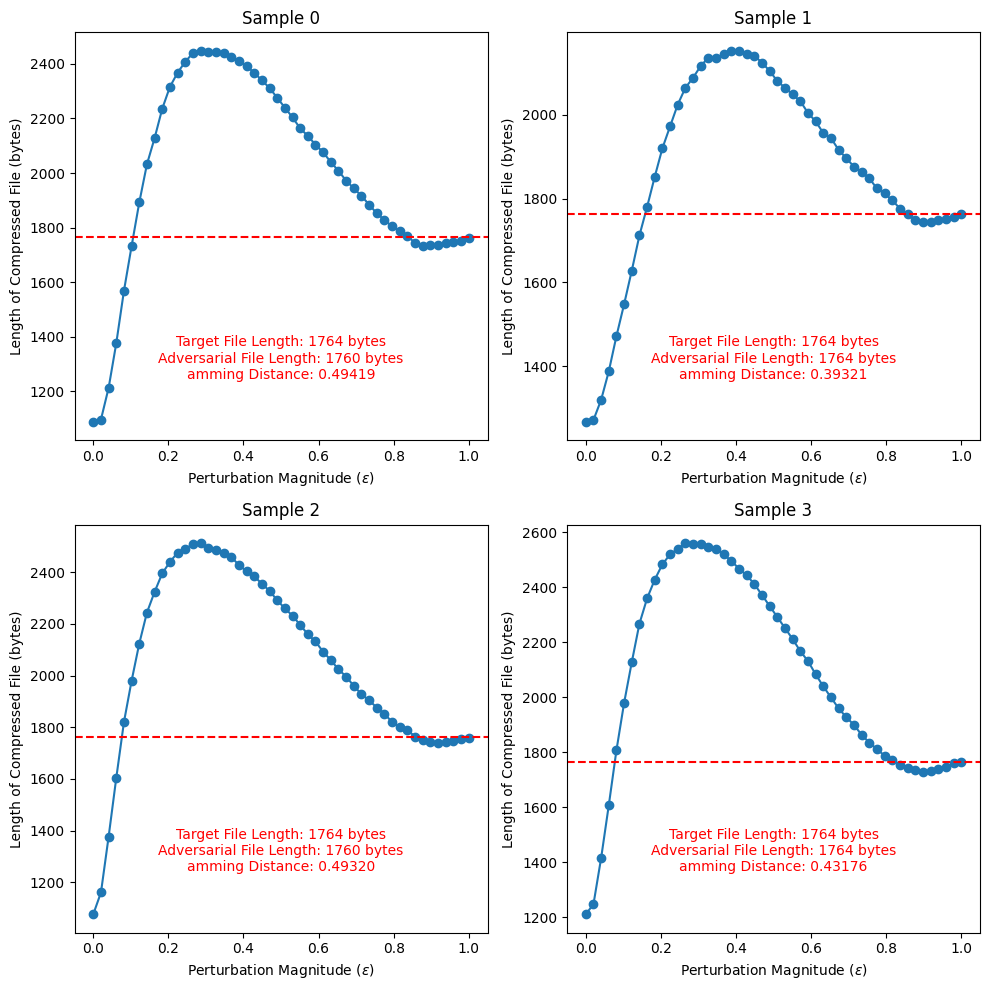

In [19]:
fig, axs = plt.subplots(num_sources // 2, 2, figsize=(10, 10))  

# Flatten axs if it's a 2D array to make indexing easier
axs = axs.ravel() if num_sources > 1 else [axs]

for idx in range(num_sources):
    # Interpolate between the source and adversarial images
    intermediate_imgs = []
    outputs = []
    sample_number = idx      # which image from the batch to visualize
    intervals = torch.linspace(0, 1, 50)
    
    for val in intervals:
        # Create an interpolated image
        intermediate = val * x_hat[sample_number] + (1 - val) * x_src[sample_number]
        intermediate_imgs.append(intermediate)

        # Pass the interpolated images through the network
        intermediate = intermediate.to(device)  # Move image to the correct device
        intermediate = intermediate.unsqueeze(0) if len(intermediate.shape) == 3 else intermediate
        
        with torch.no_grad():
            output = net(intermediate)
        outputs.append(output['x_hat'].squeeze(0).cpu())  # Assuming 'x_hat' is in the output
    
    # Get the file length of the target image
    x_out = net.compress(x)
    x_len = len(x_out['strings'][0][0])

    # Calculate the file lengths for each interpolated image
    file_lengths = []
    for i in range(len(intermediate_imgs)):
        img = intermediate_imgs[i].unsqueeze(0).to(device)  # Add batch dimension and move to device
        out = net.compress(img)
        file_len = len(out['strings'][0][0])
        file_lengths.append(file_len)

    # Plot the file lengths vs interpolation intervals
    axs[idx].plot(intervals.cpu(), file_lengths, marker='o')
    axs[idx].set_xlabel('Perturbation Magnitude ($\\epsilon$)')
    axs[idx].set_ylabel('Length of Compressed File (bytes)')
    axs[idx].set_title(f'Sample {sample_number}')
    axs[idx].axhline(y=x_len, color='r', linestyle='--', label='Original Image Length')

    # Calculate Hamming distance between the target and adversarial image compression
    bytes1 = x_out['strings'][0][0]
    bytes2 = net.compress(intermediate_imgs[-1].unsqueeze(0).to(device))['strings'][0][0]  # Use the second-to-last intermediate image

    hamming_dist = 0
    for byte1, byte2 in zip(bytes1, bytes2):
        hamming_dist += bin(byte1 ^ byte2).count('1')
    
    normalized_hamming_dist = hamming_dist / (len(bytes1) * 8)

    # Display Hamming distance on the plot
    txt = f'Target File Length: {len(bytes1)} bytes\nAdversarial File Length: {len(bytes2)} bytes\namming Distance: {normalized_hamming_dist:.5f}'
    axs[idx].text(0.5, 0.2, txt, 
                  horizontalalignment='center', verticalalignment='center', 
                  transform=axs[idx].transAxes, fontsize=10, color='red')

# Adjust layout to prevent overlapping subplots
plt.tight_layout()
plt.show()


Check if the perturbations are tranferrable between images.

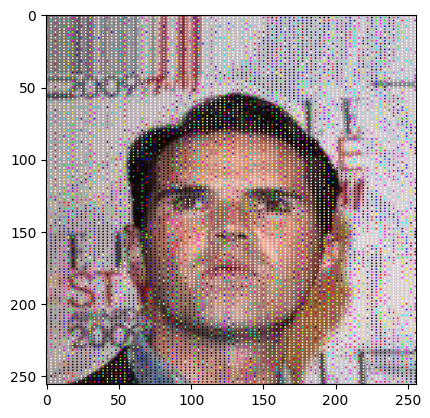

In [17]:
delta = x_adv[0] - x_src[0]
new_src = dataset[68][0].to(device) + delta
out = net.forward(new_src.unsqueeze(0))['x_hat']
plt.imshow(new_src.squeeze(0).clip(0, 1).permute(1, 2, 0).detach().cpu())

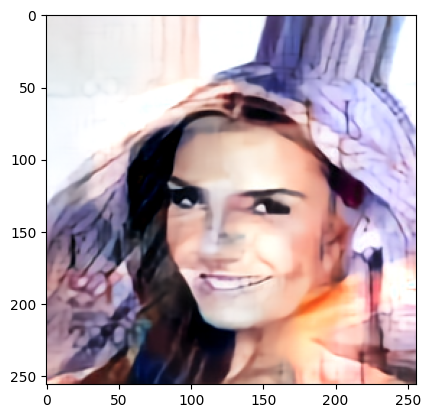

In [18]:
plt.imshow(out.squeeze(0).clip(0, 1).permute(1, 2, 0).detach().cpu())